# 03_baseline_models



In [7]:
import os
import math
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
import logging

# Improve resolution of output graphcis
%config InlineBackend.figure_format ='retina'

In [2]:
file_path = '../data/interim/NYC_capital_projects_3yr.csv'
    
if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [3]:
data = pd.read_csv(file_path)

In [4]:
# entries
print(f"Number of dataset records: {len(data)}")

# num projects
print(f"Number of unique projects in dataset: {len(data['PID'].unique())}")

Number of dataset records: 149
Number of unique projects in dataset: 149


In [5]:
datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data[col] = pd.to_datetime(data[col])

In [6]:
data.info()

data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PID                    149 non-null    int64         
 1   Project_Name           149 non-null    object        
 2   Description            149 non-null    object        
 3   Category               149 non-null    object        
 4   Borough                149 non-null    object        
 5   Managing_Agency        149 non-null    object        
 6   Client_Agency          149 non-null    object        
 7   Phase_Start            149 non-null    object        
 8   Current_Project_Years  149 non-null    float64       
 9   Current_Project_Year   149 non-null    int64         
 10  Design_Start           149 non-null    datetime64[ns]
 11  Budget_Start           149 non-null    float64       
 12  Schedule_Start         149 non-null    datetime64[ns]
 13  Final

,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Phase_Start,Current_Project_Years,Current_Project_Year,...,Schedule_Change,Budget_Change,Schedule_Change_Ratio,Budget_Change_Ratio,Budget_Abs_Per_Error,Budget_Rel_Per_Error,Duration_End_Ratio,Budget_End_Ratio,Duration_Ratio_Inv,Budget_Ratio_Inv
0,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,5.94,6,...,91,"-15,619,967.29",0.04,-0.08,0.09,0.08,1.04,0.92,-0.04,0.09
1,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,2-Design,6.34,7,...,334,"9,618,785.30",0.19,0.18,0.15,0.18,1.19,1.18,-0.16,-0.15
2,91,Mill Basin Bridge Replacement,Complete replacement of bascule bridge with a ...,Bridges,Brooklyn,DOT,not_specified,2-Design,7.44,8,...,247,"-34,672,662.00",0.09,-0.09,0.10,0.09,1.09,0.91,-0.08,0.10


## Inspect projects by category

Can any categories be combined to better balance and reduce the number of categories for one-hot-encoding in the baseline model. 

In [7]:
category_values = data['Category'].value_counts()
category_names = category_values.index

print(category_values)
print('\n')
for name in category_names:
    print(name.upper())
    print()
    for project in data.loc[data['Category']==name]['Project_Name']:
        print(project)
    print('\n')

Streets and Roadways                  31
Sewers                                20
Industrial Development                15
Schools                               15
Wastewater Treatment                  13
Water Supply                          13
Bridges, Streets and Roadways          9
Bridges                                7
Sanitation                             6
Other Government Facilities            4
Public Safety and Criminal Justice     4
Health and Hospitals                   3
Ferries                                3
Arts and Culture                       2
Parks                                  2
Industrial Development, Parks          1
Parks, Streets and Roadways            1
Name: Category, dtype: int64


STREETS AND ROADWAYS

Bergen Avenue Street Reconstruction
Dumbo and Vinegar Hill Area Roadway Reconstruction and Renovation
Edgewood Triangle Roadway Reconstruction
Battery Park Underpass Sandy Flood Damage Repair
Gansevoort Area Roadway Reconstruction
Woodhaven Blvd SBS


In [8]:
magency_values = data['Managing_Agency'].value_counts()
magency_names = magency_values.index

print(magency_values)
print('\n')
for name in magency_names:
    print(name.upper())
    print()
    for project in data.loc[data['Managing_Agency']==name]['Project_Name']:
        print(project)
    print('\n')

DDC     63
DOT     34
DEP     19
SCA     15
EDC     14
DSNY     2
DCAS     2
Name: Managing_Agency, dtype: int64


DDC

Bergen Avenue Street Reconstruction
West 30th Street Trunk Water Main Installations, Phase 2
Pugsley Creek Sewer Relief and Water Main Repair
Queens Water Main New Installations
Dumbo and Vinegar Hill Area Roadway Reconstruction and Renovation
Edgewood Triangle Roadway Reconstruction
West 59th Street Marine Transfer Station Construction, Phase 2
Flatbush Avenue Trunk Watermain Replacement
Fresh Creek Basin Sewers Construction, Phase II
Baisley Boulevard Sewers and Watermain Construction
Fresh Creek Basin Sewers Construction, Phase III
2nd Avenue Watermain Trunk Construction
Francis Lewis Boulevard Construction
Fresh Creek Basin Sewers Construction, Phase I
Gansevoort Area Roadway Reconstruction
Hudson Yards Cultural Shed Facility New Construction
20th Avenue Storm and Sanitary Sewer Construction
Bainbridge Avenue Trunk Water Main
Ped Safety Upgrades on Atlantic Avenue

In [9]:
cagency_values = data['Client_Agency'].value_counts()
cagency_names = cagency_values.index

print(cagency_values)
print('\n')
for name in cagency_names:
    print(name.upper())
    print()
    for project in data.loc[data['Client_Agency']==name]['Project_Name']:
        print(project)
    print('\n')

DEP                    53
not_specified          35
DOT                    17
DOE                    15
DSNY                    7
DCAS                    4
DPR                     3
H+H                     3
DCLA                    2
DHS                     1
EDC                     1
NYPD                    1
DEP, EDC                1
DOHMH, HHC              1
Mayor's Office          1
BWS                     1
DOT, Mayor's Office     1
DSBS                    1
ORR                     1
Name: Client_Agency, dtype: int64


DEP

26th Ward Waste Water Treatment Plant Preliminary Treatment Improvements
Bowery Bay Waste Water Treatment Plant Main Sewage Pump Controls and Piping Replacements
West 30th Street Trunk Water Main Installations, Phase 2
Pugsley Creek Sewer Relief and Water Main Repair
Queens Water Main New Installations
Wards Island Water Pollution Control Plant final Settling Tank Rehabilitation
Hannah Street Pumping Station Construction
Coney Island Biological Nutrient Constru

In [10]:
borough_values = data['Borough'].value_counts()
borough_names = borough_values.index

print(borough_values)
print('\n')
for name in borough_names:
    print(name.upper())
    print()
    for project in data.loc[data['Borough']==name]['Project_Name']:
        print(project)
    print('\n')

not_specified                      47
Brooklyn                           30
Queens                             19
Manhattan                          17
Bronx                              12
Staten Island                       9
Citywide                            5
Valhalla                            2
New York                            2
Olive                               1
Port Jervis                         1
Manhattan, Bronx                    1
Marlboro                            1
Manhattan, Staten Island, Bronx     1
Brooklyn, Queens                    1
Name: Borough, dtype: int64


NOT_SPECIFIED

New Ferry Boat Construction
Woodhaven Blvd SBS
Grand Concourse, Phase 3
Grand Concourse Reconstruction, Phase 4 (Great Streets)
Queens Boulevard Reconstruction (Great Streets)
Hunters Point Street Reconstruction (Long Island City)
Brookville-Edgewood Triangle Reconstruction
FDR Rehabilitation, Northbound (East 42nd to 49th Streets)
Ped Safety Upgrades on Atlantic Avenue, Phase 2
Hen

## Subset and scale data for X and y frames

In [41]:
def scale_features(train_df, val_df, exclude_scale_cols=[], scaler=RobustScaler,
                   scale_before_func=None, scale_after_func=None,
                   reapply_scaler=False, **kwargs):
    """Scales val_df features based on train_df and returns scaled dataframe
    
    Accepts various sklearn scalers and allows you to specify features you do not
    want affected by scaling by using the exclude_scale_cols parameter.
    
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param exclude_scale_cols: Optional list containing names of columns we
                               do not wish to scale, default=[]
    :param scaler: The sklearn scaler method used to fit the data (i.e. StandardScaler,
                    MinMaxScaler, RobustScaler, etc.), default=RobustScaler
    :param scale_before_func: Optional function (i.e. np.log, np.sigmoid, or custom
                              function) to be applied to train and val dfs prior to the
                              scaler fitting and scaling val_df, default=None
    :param scale_after_func: Optional function (i.e. np.log, np.sigmoid, or custom
                             function) to be applied to val_df after the scaler has
                             scaled the datafrme
    :param reapply_scaler: Boolean, if set to True, the scaler is fitted a second time
                           after the scale_after_func is applied (useful if using
                           MinMaxScaler and you wish to maintain a 0 to 1 scale after
                           applying a secondary transformation to the data), default
                           is reapply_scaler=False
    :param kwargs: Any additional arguments are passed as parameters to the selected
                   scaler (for instance feature_range=(-1,1) would be an appropriate
                   argument if scaler is set to MinMaxScaler)
    :return: a feature-scaled version of the val_df dataframe, and a list of fitted
             sklearn scaler objects that were used to scale values (for later use in
             case original values need to be restored), list will either be of length
             1 or 2 depending on whether reapply_scaler was set to True
    """
    # create list of columns to ensure proper ordering of columns for output df
    col_list = list(train_df)
    
    # create list of non-binary column names for scaling
    scaled_columns = train_df.columns.difference(exclude_scale_cols)
    
    # apply initial scaling if specified
    if scale_before_func:
        train_df = scale_before_func(train_df.copy()[scaled_columns])
        val_df = scale_before_func(val_df.copy()[scaled_columns])
        
    # initialize list for storing fitted scaler objects
    Scaler = []
    
    # create Scaler instance fitted on non-binary train data
    Scaler.append(
        scaler(**kwargs).fit(train_df[scaled_columns])
    )
    
    # scale val_df and convert to dataframe with column names
    scaled_train_df = pd.DataFrame(
        Scaler[0].transform(train_df[scaled_columns]),
        columns=scaled_columns,
    )

    scaled_val_df = pd.DataFrame(
        Scaler[0].transform(val_df[scaled_columns]),
        columns=scaled_columns,
    )
    
    # apply initial scaling if specified
    if scale_after_func:
        scaled_train_df = scale_after_func(scaled_train_df.copy())
        scaled_val_df = scale_after_func(scaled_val_df.copy())

    # create StandardScaler instance fitted on non-binary train data
    if reapply_scaler:
        Scaler.append(
            scaler(**kwargs).fit(scaled_train_df[scaled_columns])
        )
        
        scaled_val_df = pd.DataFrame(
            Scaler[1].transform(scaled_val_df[scaled_columns]),
            columns=scaled_columns,
        )
    
    # merge scaled columns with unscaled columns
    scaled_df = pd.concat(
        [
            val_df.drop(scaled_columns, axis=1).reset_index(drop=True),
            scaled_val_df.copy()
        ],
        axis=1,
    )[col_list]
    
    # Return full scaled val dataframe and fitted Scaler object list
    return scaled_val_df, Scaler


def sigmoid(x):
    """Efficient numpy-based sigmoid transformation of a dataframe, array, or matrix
    
    :param x: data to undergo transformation (datatypes accepted include,
              pandas DataFrames and Series, numpy matrices and arrays, or single
              int or float values x)
    :return: The transformed dataframe, series, array, or value depending on
             the type of original input x object
    """
    return 1/(1 + np.exp(-x)) 


def log_plus_one(x):
    """Adds 1 to the input data and then applies Log transformation to those values
    
    :param x: data to undergo transformation (datatypes accepted include,
              pandas DataFrames and Series, numpy matrices and arrays, or single
              int or float values x)
    :return: The transformed dataframe, series, array, or value depending on
             the type of original input x object
    """
    return np.log(x + 1)

In [15]:
X_cols = [
    'Budget_Start',
    'Duration_Start',
]

y_cols = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]


In [16]:
X, y = data[X_cols], data[y_cols]

In [17]:
random_state = 0
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

In [31]:
print('{}\t{}'.format(X_train.shape, y_train.shape))
print('{}\t\t{}'.format(X_test.shape, y_test.shape))

(134, 2)	(134, 2)
(15, 2)		(15, 2)


In [47]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify columns to exclude from scaling (i.e. binary and non-predictor columns)
exclude_scale_cols = []

# Perform standard scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None

X_train_stdz, Scaler_stdz = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_stdz, Scaler_stdz = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

# Perform standard scaling and then pass through sigmoid transformation
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid

X_train_stdz_sig, _ = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_stdz_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)


# Perform normalized scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = MinMaxScaler
scale_before_func = None
scale_after_func = None

X_train_norm, Scaler_norm = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_norm, Scaler_norm = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)


# Perform normalized scaling then add 1 and perform log transformation and renormalize
scaler = MinMaxScaler
scale_before_func = None
scale_after_func = log_plus_one
reapply_scaler = True

X_train_norm_log, _ = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_norm_log, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Perform 'Robust' scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = RobustScaler
scale_before_func = None
scale_after_func = None

X_train_rob, Scaler_rob = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_rob, Scaler_rob = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)



In [43]:
X_train_norm_log.describe()

,Budget_Start,Duration_Start
count,134.00,134.00
mean,0.05,0.29
std,0.08,0.12
min,0.00,0.00
25%,0.02,0.20
50%,0.03,0.29
75%,0.04,0.36
max,0.69,0.69


In [44]:
X_train_norm_log2.describe()

,Budget_Start,Duration_Start
count,134.00,134.00
mean,0.07,0.42
std,0.12,0.18
min,0.00,0.00
25%,0.02,0.30
50%,0.04,0.41
75%,0.06,0.51
max,1.00,1.00


In [40]:
type(2.4) in (pd.core.series.Series, pd.core.frame.DataFrame)

False

In [39]:
type(y_train) in (pd.core.series.Series, pd.core.frame.DataFrame)

True

In [38]:
type(y_train['Budget_Change_Ratio']) in (pd.core.series.Series, pd.core.frame.DataFrame)

True

## Define functions for fitting and evaluating models

In [27]:
def score_outputs(y_train, y_test, pred_train, pred_test):
    """Returns R2 scores for train and test predictions
    
    This function will work for either single- or multi-output predictions
    and accepts either pandas Series or DataFrame or numpy array objects as
    inputs
    
    :return: tuple containing 2 lists of R2 scores, one list for train
             and one list for test scores. Each list contains a score
             for each feature predicted (i.e. budget and duration) if
             multi-output prediction was used, or a single score if
             single-output prediction was used
    """
    if type(y_train) in (pd.core.series.Series, pd.core.frame.DataFrame):
        y_train = y_train.values
        
    if type(y_test) in (pd.core.series.Series, pd.core.frame.DataFrame):
        y_test = y_test.values
        
    score_train = [
        r2_score(true, pred) for true, pred in zip(y_train.T, pred_train.T)
    ]
    score_test = [
        r2_score(true, pred) for true, pred in zip(y_test.T, pred_test.T)
    ]
    
    return score_train, score_test

In [28]:
LinReg = LinearRegression()
LinReg.fit(X_train_scaled, y_train)
pred_train = LinReg.predict(X_train_scaled)
pred_test = LinReg.predict(X_test_scaled)
score_train = r2_score(y_train, pred_train)
score_test = r2_score(y_test, pred_test)

In [29]:
score_outputs(y_train, y_test, pred_train, pred_test)

([0.07645560085392966, 0.0740551717265594],
 [-0.04207160171390911, 0.17907057183667097])

In [30]:
type(None)

NoneType

## Define plotting functions to inspect scaled input data and regression results

In [77]:
def plot_budget_schedule(X, X_scaled, scale_descr, X_test=None, X_test_scaled=None):
    """Plots original vs scaled versions of budget and schedule input data
    
    :param X: Dataframe or 2D array with original budget and schedule train data
    :param X_scaled: Dataframe or 2D array with scaled budget and schedule train data
    :param scale_descr: Short string description of scaling transformation used
                        to title scaled data plot (e.g. 'Sigmoid Standardized')
    :param X_test: Optional, Dataframe or 2D array with original test data, which
                   will plot test data as overlay with training data (default is
                   X_test=None, which does not plot any overlay)
    :param X_test_scaled: Optional, Dataframe or 2D array with original test data,
                          which plots overlay similar to X_test (default is
                          X_test_scaled=None)
                          
    :return: Generates 1x2 subplotted scatterplots, no objects returned
    """
    corr = np.corrcoef(X.T)[0, 1]
    corr_scaled = np.corrcoef(X_scaled.T)[0, 1]

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    
    plt.suptitle(
        'Original budget and duration values vs. {} scaled values'.format(scale_descr),
        y=1.05,
        fontsize=18
    )
    
    for i, (data, data_test) in enumerate(zip([X, X_scaled], [X_test, X_test_scaled])):
        ax[i].scatter(
            *data.values.T,
            color='k',
            alpha=0.5,
            edgecolor='w',
            s=80,
            label='training obs'
        )
        ax[i].set_title(
            'Original data\n({:.2f} pearson coefficient)'.format(corr) if i==0
            else '{} scaled\n({:.2f} pearson coefficient)'.format(scale_descr, corr_scaled),
            fontsize=14
        )
        ax[i].set_xlabel('Budget', fontsize=12)
        if i==0:
            ax[i].set_ylabel('Duration (days)', fontsize=12)

        if type(X_test)!='NoneType':
            ax[i].scatter(
                *data_test.values.T,
                color='tab:orange',
                alpha=1,
                edgecolor='w',
                marker='s',
                s=80,
                label='test obs'
            )
            ax[0].legend(fontsize=12, edgecolor='k', loc=4)
            
        ax[i].grid(':', alpha=0.4)
    plt.tight_layout()
    plt.show();
    
    
def plot_true_pred(y, y_pred, model_descr, test=False,
                   xlabel='Budget after year-3',
                   ylabel='Duration (in days) after year-3'):
    """
    """
    var_labels = [xlabel, ylabel]
    if type(y)==pd.core.frame.DataFrame:
        y = y.copy().values
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    plt.title(
        '{} true vs. predicted values for {}'.format(
            'Test' if test else 'Training', model_descr
        ),
        fontsize=18
    )
    
    plt.scatter(
        *y.T,
        color='k',
        alpha=0.5,
        edgecolor='w',
        s=90,
        label='true values'
    )
    plt.scatter(
        *y_pred.T,
        color='tab:orange',
        alpha=0.5,
        edgecolor='w',
        marker='s',
        s=90,
        label='predicted values'
    )
    
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    ax.legend(fontsize=12, edgecolor='k')
            
    ax.grid(':', alpha=0.4)
    plt.tight_layout()
    plt.show();
    
    fig, axes = plt.subplots(1,2, figsize=(12,5))
        
    for i, (ax, true, pred) in enumerate(zip(axes.flat, y.T, y_pred.T)):
        ax.scatter(
            true, pred,
            color='k',
            alpha=0.5,
            edgecolor='w',
            s=80
        )
        ax.set_title('{}'.format(var_labels[i]), fontsize=14)
        ax.set_xlabel('true value', fontsize=12)
        if i==0:
            ax.set_ylabel('predicted value', fontsize=12)
        ax.axis('equal')
        ax.grid(':', alpha=0.4)
        
    plt.tight_layout()
    plt.show();

    fig, axes = plt.subplots(1,2, figsize=(12,3))
        
    for i, (ax, true, pred) in enumerate(zip(axes.flat, y.T, y_pred.T)):        
        ax.scatter(
            true, pred-true,
            color='k',
            alpha=0.5,
            edgecolor='w',
            s=80
        )
        ax.axhline(0, color='k', linestyle='--')
        ax.set_xlabel('true value', fontsize=12)
        if i==0:
            ax.set_ylabel('prediction error', fontsize=12)
        ax.grid(':', alpha=0.4)

    plt.tight_layout()
    plt.show();

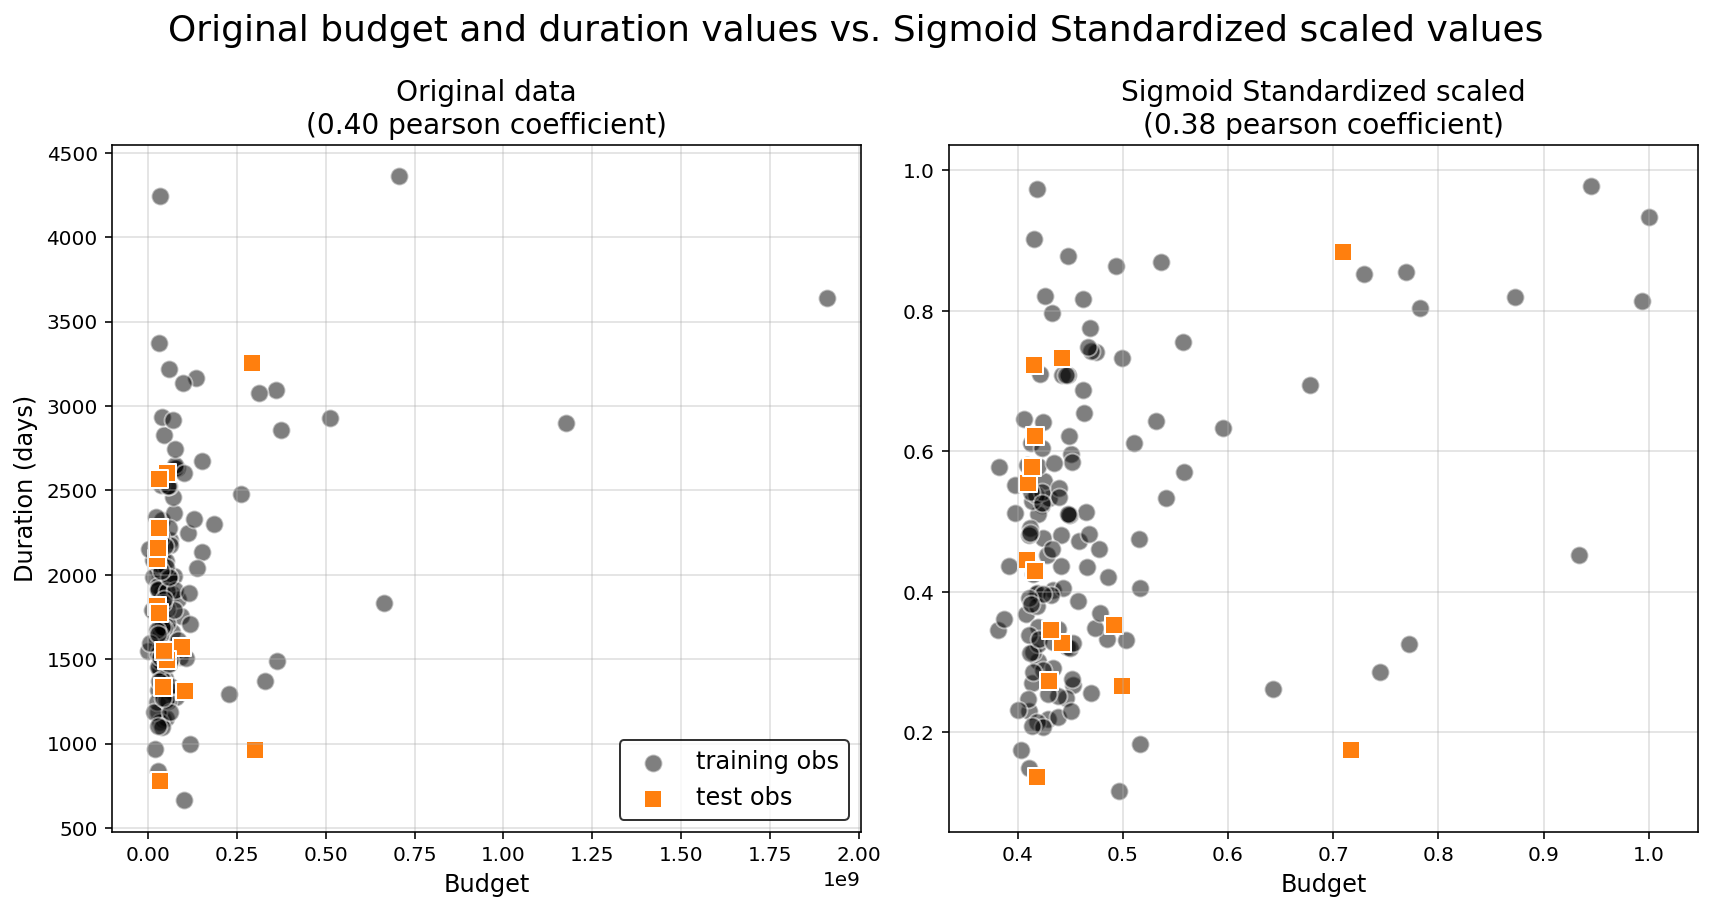

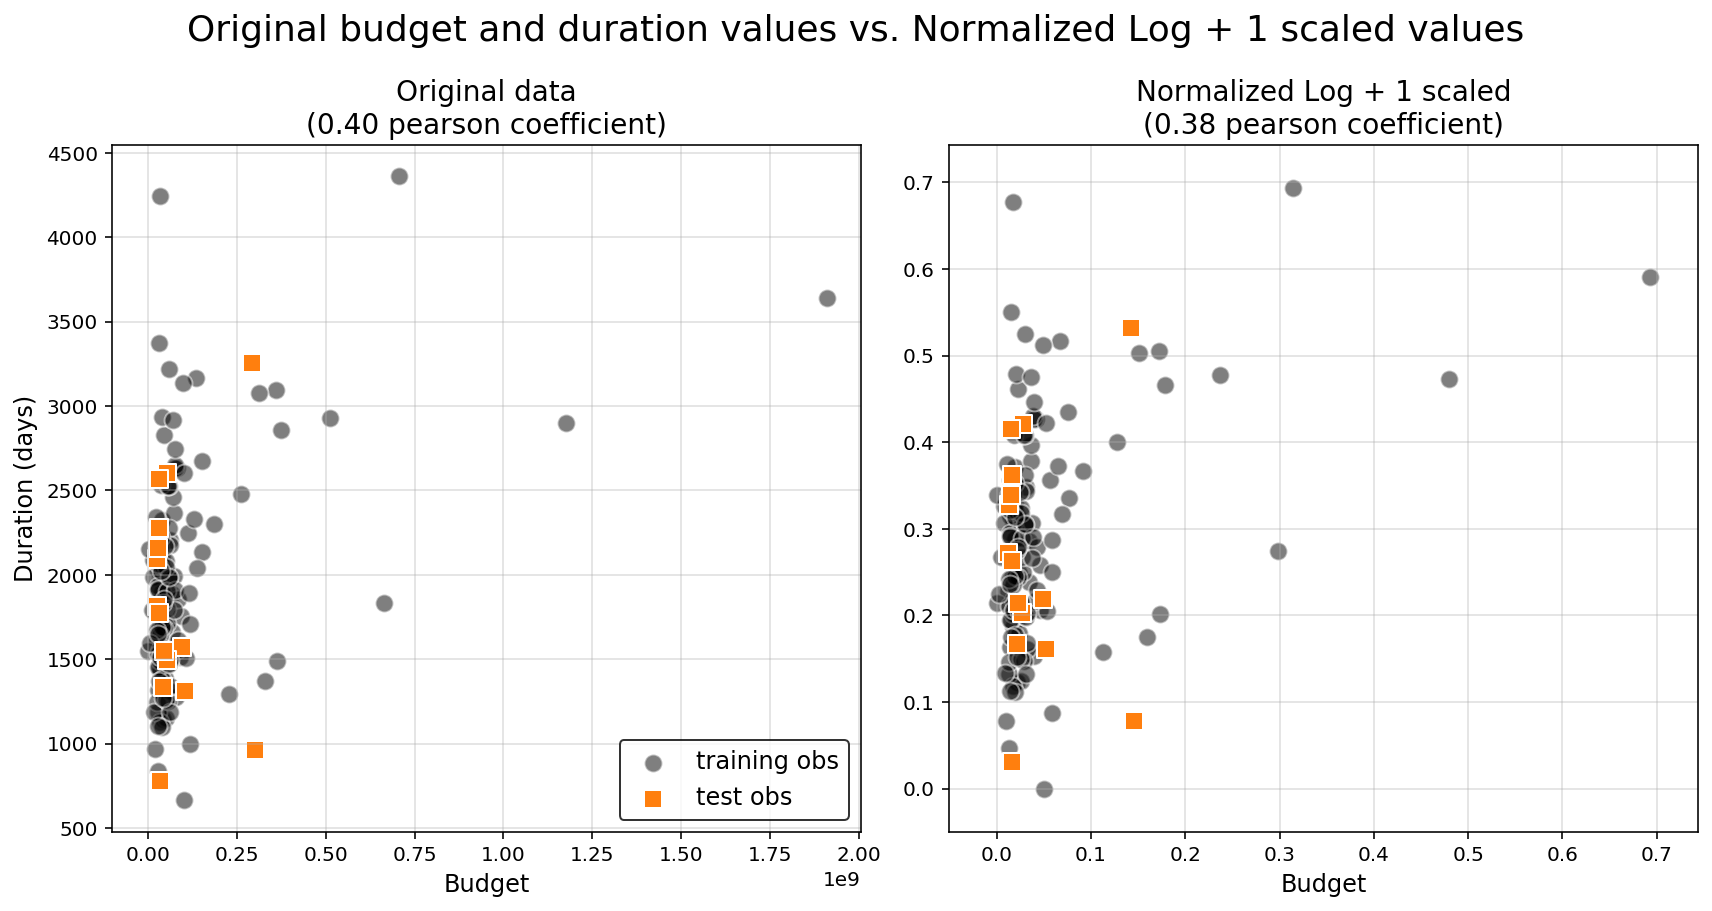

In [32]:
plot_budget_schedule(X_train, X_train_sig, 'Sigmoid Standardized', X_test, X_test_sig)
plot_budget_schedule(X_train, X_train_log, 'Normalized Log + 1', X_test, X_test_log)

In [33]:
LinReg = LinearRegression()
LinReg.fit(X_train_sig, y_train)
pred_train = LinReg.predict(X_train_sig)
pred_test = LinReg.predict(X_test_sig)
score_train = r2_score(y_train, pred_train)
score_test = r2_score(y_test, pred_test)

In [34]:
score_outputs(y_train, y_test, pred_train, pred_test)

([0.10799612779875323, 0.0662089049849558],
 [-0.9163101329216001, 0.20420024495648714])

In [35]:
LinReg = LinearRegression()
LinReg.fit(X_train_log, y_train)
pred_train = LinReg.predict(X_train_log)
pred_test = LinReg.predict(X_test_log)
score_train = r2_score(y_train, pred_train)
score_test = r2_score(y_test, pred_test)

In [36]:
score_outputs(y_train, y_test, pred_train, pred_test)

([0.09214302920999573, 0.084079658562499],
 [-0.1598473827889062, 0.20969809973494324])

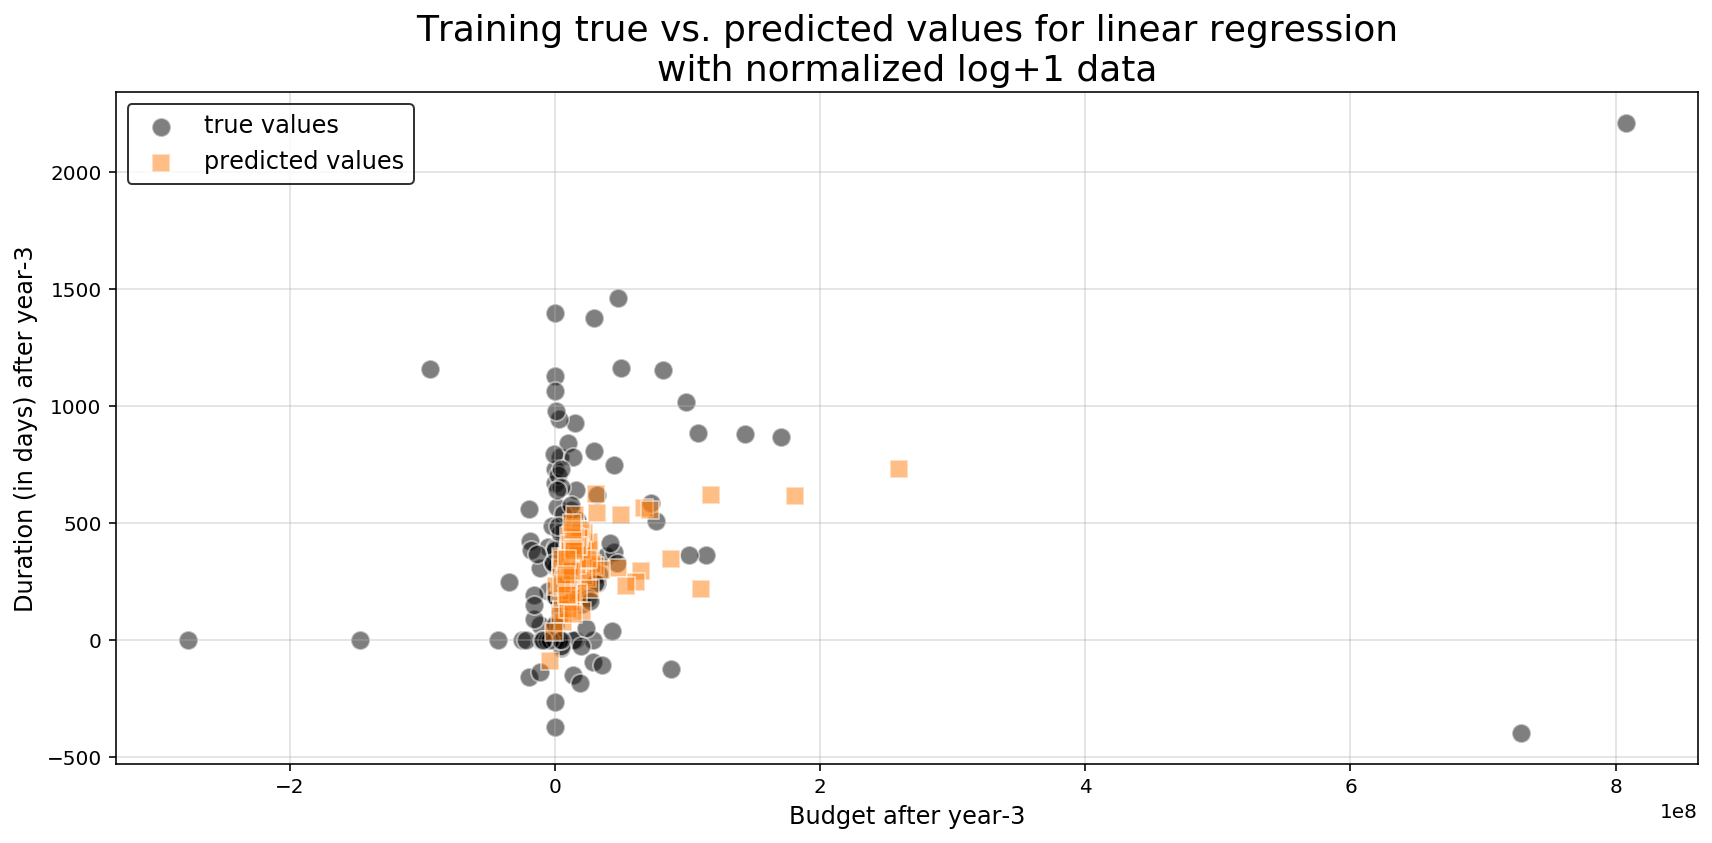

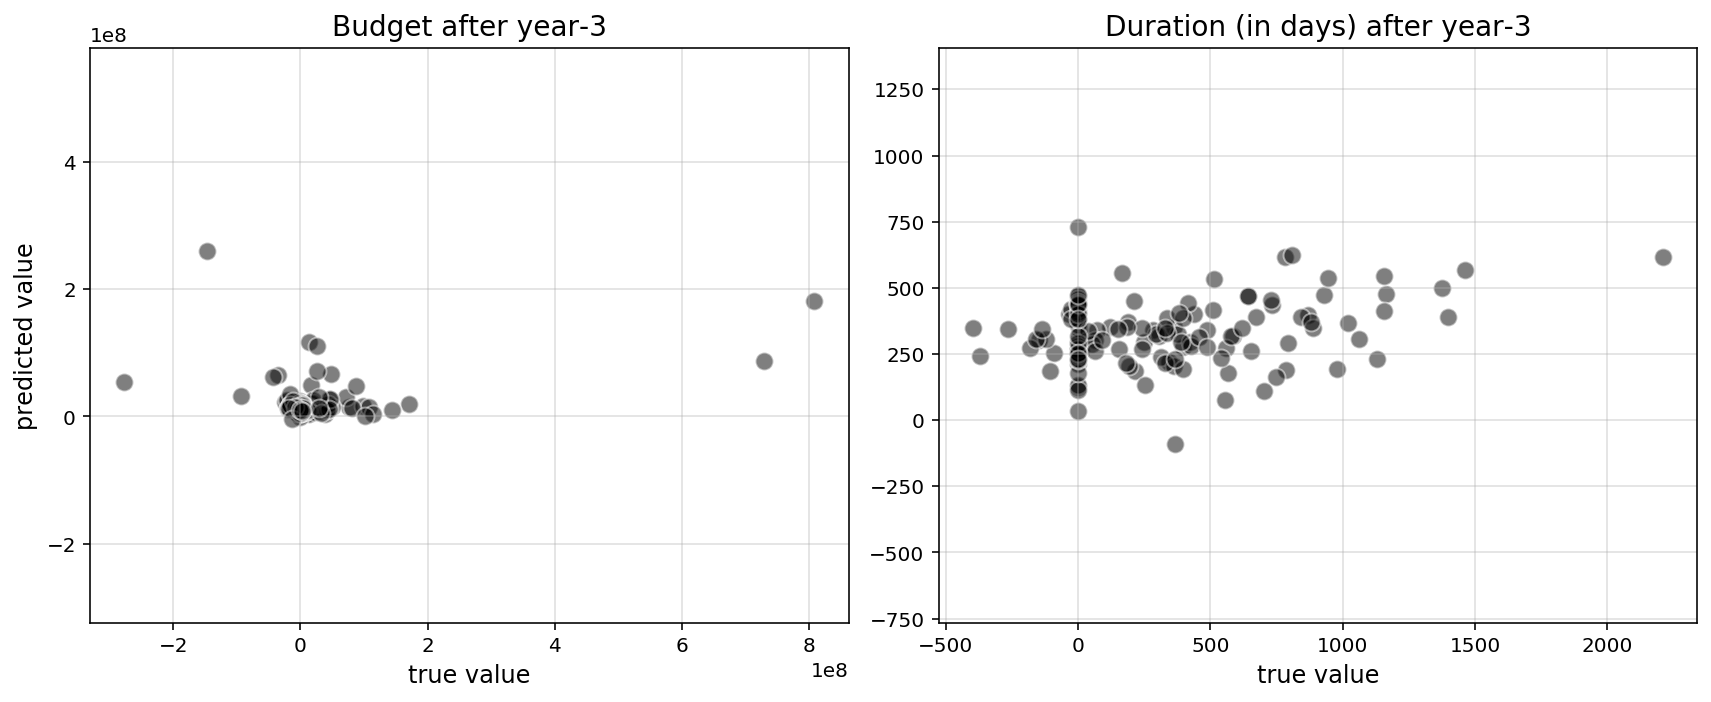

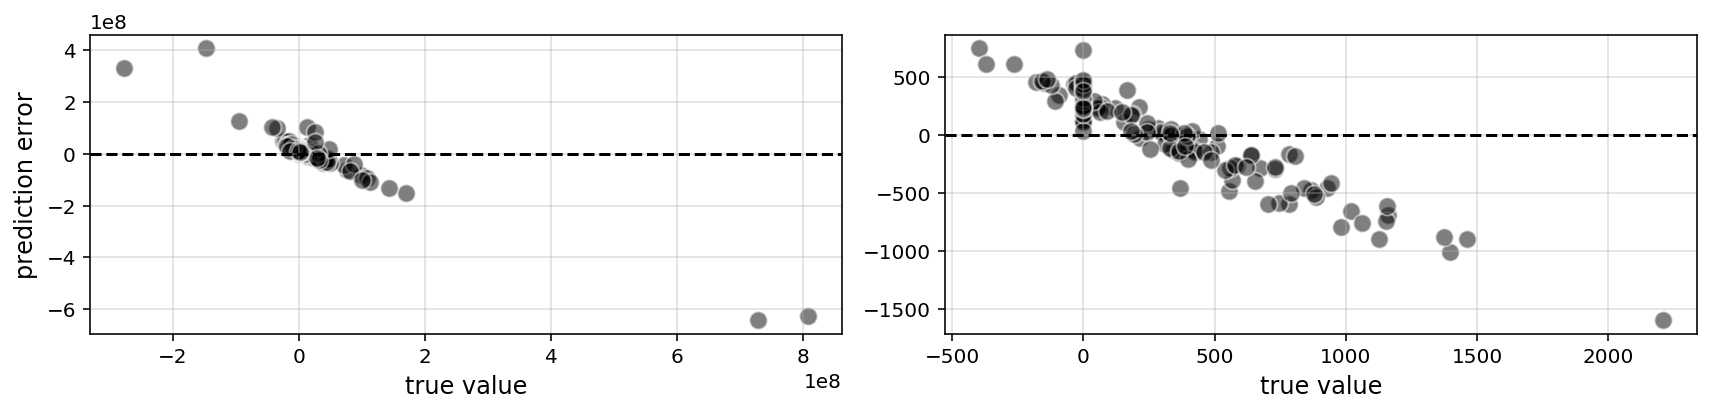

In [78]:
model_descr = 'linear regression\nwith normalized log+1 data'
plot_true_pred(y_train, pred_train, model_descr, test=False)

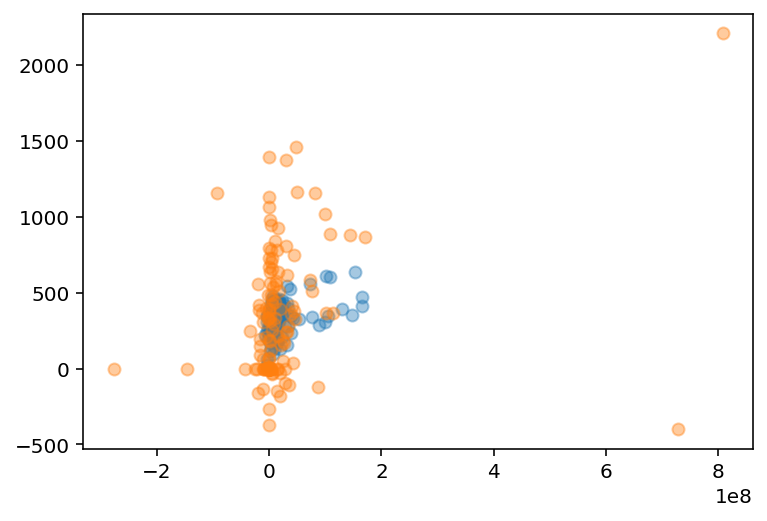

In [123]:
plt.scatter(pred_train[:, 0], pred_train[:, 1], alpha=0.4)
plt.scatter(y_train['Budget_Change'].values, y_train['Schedule_Change'].values, alpha=0.4)

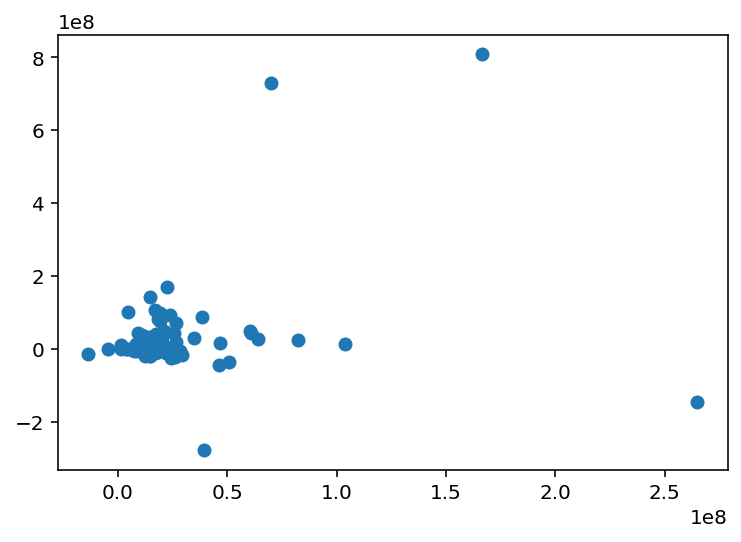

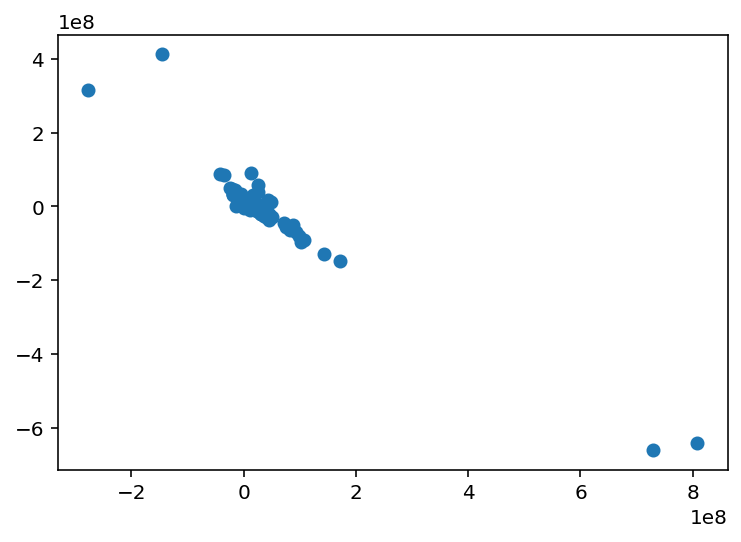

In [80]:
plt.scatter(pred_train[:, 0], y_train['Budget_Change'].values)
plt.show();

plt.scatter(y_train['Budget_Change'].values, pred_train[:, 0]-y_train['Budget_Change'].values)
plt.show();

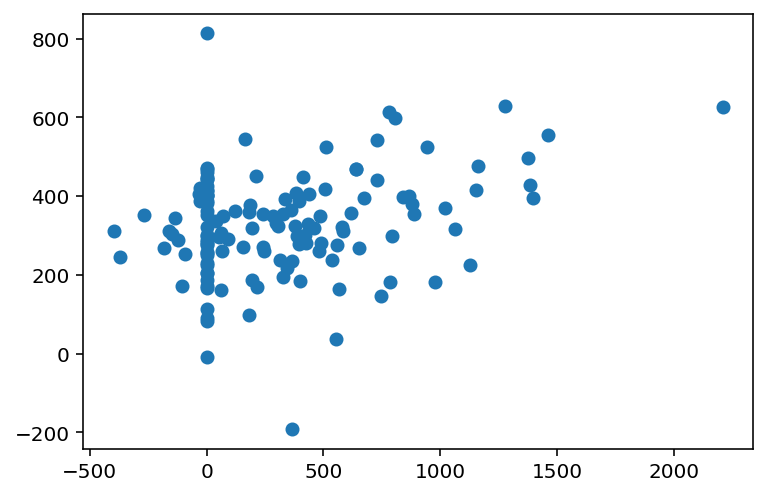

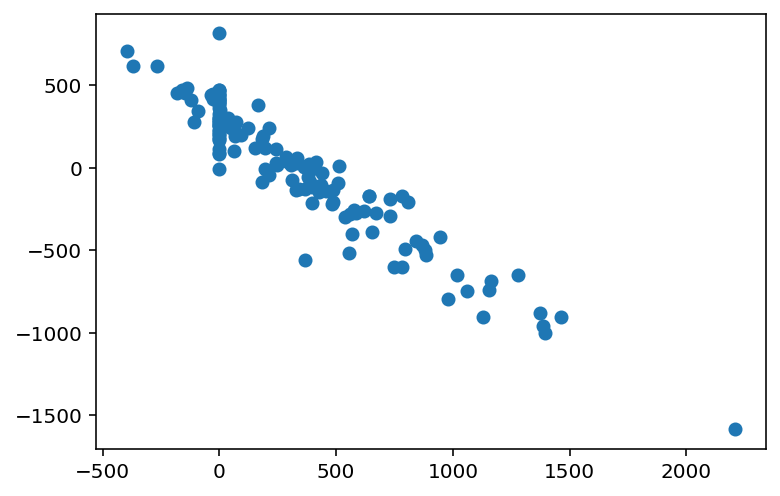

In [81]:
plt.scatter(y_train['Schedule_Change'].values, pred_train[:, 1])
plt.show();

plt.scatter(y_train['Schedule_Change'].values, pred_train[:, 1]-y_train['Schedule_Change'].values)
plt.show();

In [32]:
y_train

,Budget_Change,Schedule_Change
14,"4,772,000.00",654
83,"4,852,287.00",-34
105,0.00,0
28,"48,000,000.00",1461
120,"20,759,000.00",154
...,...,...
33,"29,558,000.00",196
75,"13,644,140.00",783
143,0.00,0
141,"-3,769,531.00",0
